<a href="https://colab.research.google.com/github/xmuhammadaziz09/Rumah_adat_deeplearning/blob/main/uas_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import core libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda v: f'{v:.3f}')

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_theme(style='whitegrid')
%matplotlib inline

In [2]:
# Cell 2: Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models # Import models module
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import os
import glob
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import itertools # For plotting confusion matrix

In [3]:
# Cell 3: Set Kaggle API credentials
import os
os.environ["KAGGLE_USERNAME"] = "samprul"
os.environ["KAGGLE_KEY"] = "b40788d8a48fec1c8e173749fafa9116"

In [4]:
# Cell 4: Download and extract dataset

!kaggle datasets download -d samprul/rumah-adat
!unzip -q rumah-adat.zip -d /content/
!rm rumah-adat.zip

Dataset URL: https://www.kaggle.com/datasets/samprul/rumah-adat
License(s): unknown
 80% 122M/152M [00:00<00:00, 1.27GB/s]
100% 152M/152M [00:00<00:00, 1.18GB/s]


In [5]:
# Cell 5: Define custom dataset for image loading (NO CHANGE NEEDED)
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Collect image paths and assign labels
        class_names_sorted = sorted(os.listdir(root_dir))
        for i, class_name in enumerate(class_names_sorted):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = i
                self.idx_to_class[i] = class_name
                for img_name in os.listdir(class_path):
                    # Hanya tambahkan gambar yang belum diaugmentasi secara statis
                    # atau gambar asli saja jika Anda memisahkan folder
                    # Dengan cara augmentasi statis yang saya berikan di Cell 4b,
                    # semua file (asli & augmented) akan dibaca di sini
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(i)

        self.transform = transform
        self.classes = [self.idx_to_class[i] for i in sorted(self.idx_to_class.keys())] # Ensure order for class_names

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Cell 6: Data Preprocessing and Augmentation (UPDATED)
data_dir = '/content/rumah_adat' # Sesuaikan dengan lokasi folder dataset Anda

# Define transforms for training data (WITHOUT augmentation)
# Hanya menyertakan resize, to_tensor, dan normalisasi
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),     # Resize images to 224x224
    transforms.ToTensor(),             # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# Define transforms for validation and test data (NO CHANGE - already without augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),     # Resize images to 224x224
    transforms.ToTensor(),             # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# Create the full dataset. Note: We'll apply different transforms AFTER splitting.
full_dataset_raw = CustomImageDataset(root_dir=data_dir, transform=None)
num_classes = len(full_dataset_raw.classes)
class_names = full_dataset_raw.classes # Get class names for plotting
print(f"Jumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")

Jumlah kelas: 4
Nama kelas: ['rumahgadang', 'rumahhonai', 'rumahjoglo', 'rumahtongkonan']


In [7]:
# Cell 7: Split data into training, testing, and validation sets (70:20:10) (NO CHANGE NEEDED)
dataset_size = len(full_dataset_raw)
train_size = int(0.7 * dataset_size)
test_size = int(0.2 * dataset_size)
val_size = dataset_size - train_size - test_size # Ensure all samples are covered

train_dataset_indices, test_dataset_indices, val_dataset_indices = random_split(
    range(dataset_size), [train_size, test_size, val_size])

# Now, create new datasets with appropriate transforms for each split
class TransformedSubset(Dataset):
    def __init__(self, subset_indices, original_dataset, transform=None):
        self.subset_indices = subset_indices
        self.original_dataset = original_dataset
        self.transform = transform

    def __getitem__(self, idx):
        original_idx = self.subset_indices[idx]
        image, label = self.original_dataset[original_idx] # Get raw image and label
        if self.transform:
            image = self.transform(image) # Apply transform
        return image, label

    def __len__(self):
        return len(self.subset_indices)

train_dataset = TransformedSubset(train_dataset_indices, full_dataset_raw, train_transform)
test_dataset = TransformedSubset(test_dataset_indices, full_dataset_raw, val_test_transform)
val_dataset = TransformedSubset(val_dataset_indices, full_dataset_raw, val_test_transform)


print(f"Ukuran dataset training: {len(train_dataset)}")
print(f"Ukuran dataset testing: {len(test_dataset)}")
print(f"Ukuran dataset validation: {len(val_dataset)}")


Ukuran dataset training: 560
Ukuran dataset testing: 160
Ukuran dataset validation: 80


In [8]:
# Cell 8: Create DataLoaders (NO CHANGE NEEDED)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Cell 9: Define Model Initialization Function for Pre-trained Models (Same as previous MobileNetV2, VGG16, DenseNet121)
def get_pretrained_model(model_name, num_classes, freeze_features=True):
    if model_name == "VGG16":
        model = models.vgg16(pretrained=True)
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
        # VGG16's classifier is a sequential block; modify the last linear layer
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "MobileNetV2": # Tetap MobileNetV2
        model = models.mobilenet_v2(pretrained=True)
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
        # MobileNetV2's classifier is also sequential
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "DenseNet121": #
        model = models.densenet121(pretrained=True)
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
        # DenseNet's classifier is a direct linear layer
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Model name not recognized. Choose from 'VGG16', 'MobileNetV2', 'DenseNet121'.")

    return model

In [10]:
# Cell 10: Training and Evaluation Function (NO CHANGE NEEDED)
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_classes, epochs, device, model_name, class_names):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Or you can try SGD, adjust learning rate

    print(f"\n--- Training {model_name} ---")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    print(f"Training {model_name} selesai!")

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_accuracy = accuracy_score(all_labels, all_preds) * 100
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f'\n--- Hasil Evaluasi {model_name} ---')
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1-Score: {test_f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names, model_name)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    return {'accuracy': test_accuracy, 'f1_score': test_f1, 'history': history}

In [11]:
# Cell 11: Function to plot Confusion Matrix (NO CHANGE NEEDED)
def plot_confusion_matrix(cm, classes, model_name, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'{title} for {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [12]:
# Cell 12: Function to plot training history (NO CHANGE NEEDED)
def plot_training_history(history, model_name):
    """
    Plots the training and validation accuracy and loss.
    """
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.show()


--- Memulai VGG16 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.5MB/s]


Model VGG16 loaded with 16388 trainable parameters.

--- Training VGG16 ---
Epoch 1/20, Train Loss: 0.5233, Train Acc: 82.14%, Val Loss: 0.1665, Val Acc: 97.50%
Epoch 2/20, Train Loss: 0.1119, Train Acc: 97.50%, Val Loss: 0.1061, Val Acc: 97.50%
Epoch 3/20, Train Loss: 0.0858, Train Acc: 98.21%, Val Loss: 0.0868, Val Acc: 97.50%
Epoch 4/20, Train Loss: 0.0728, Train Acc: 98.04%, Val Loss: 0.0779, Val Acc: 97.50%
Epoch 5/20, Train Loss: 0.0497, Train Acc: 99.46%, Val Loss: 0.0674, Val Acc: 98.75%
Epoch 6/20, Train Loss: 0.0412, Train Acc: 99.11%, Val Loss: 0.0669, Val Acc: 98.75%
Epoch 7/20, Train Loss: 0.0383, Train Acc: 99.29%, Val Loss: 0.0633, Val Acc: 98.75%
Epoch 8/20, Train Loss: 0.0320, Train Acc: 99.46%, Val Loss: 0.0624, Val Acc: 97.50%
Epoch 9/20, Train Loss: 0.0385, Train Acc: 99.29%, Val Loss: 0.0682, Val Acc: 96.25%
Epoch 10/20, Train Loss: 0.0299, Train Acc: 99.11%, Val Loss: 0.0663, Val Acc: 97.50%
Epoch 11/20, Train Loss: 0.0236, Train Acc: 99.82%, Val Loss: 0.0636, Val

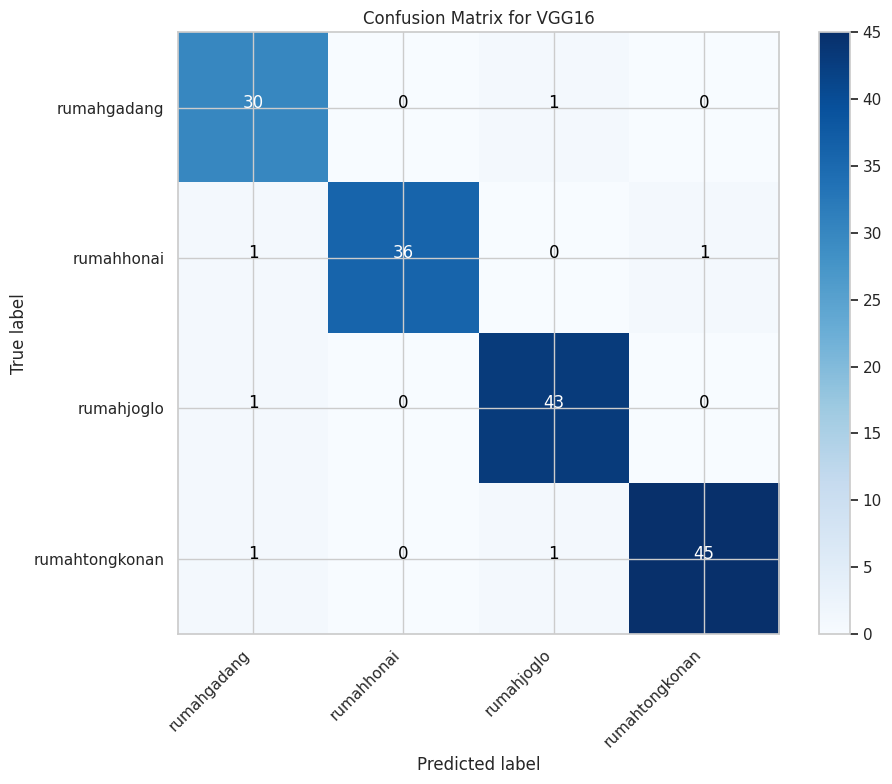


Classification Report:
                precision    recall  f1-score   support

   rumahgadang       0.91      0.97      0.94        31
    rumahhonai       1.00      0.95      0.97        38
    rumahjoglo       0.96      0.98      0.97        44
rumahtongkonan       0.98      0.96      0.97        47

      accuracy                           0.96       160
     macro avg       0.96      0.96      0.96       160
  weighted avg       0.96      0.96      0.96       160



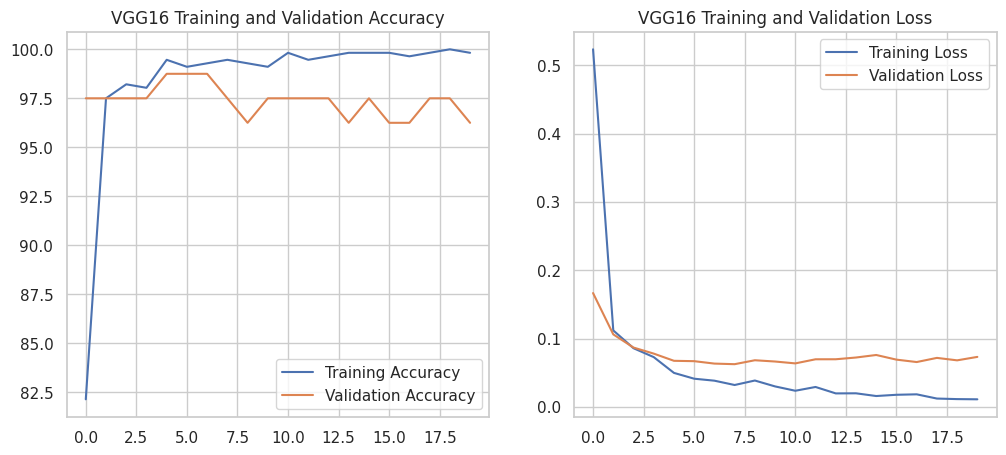


--- Memulai MobileNetV2 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 172MB/s]


Model MobileNetV2 loaded with 5124 trainable parameters.

--- Training MobileNetV2 ---
Epoch 1/20, Train Loss: 0.9636, Train Acc: 63.21%, Val Loss: 0.5980, Val Acc: 82.50%
Epoch 2/20, Train Loss: 0.4201, Train Acc: 89.11%, Val Loss: 0.3036, Val Acc: 96.25%
Epoch 3/20, Train Loss: 0.2287, Train Acc: 96.43%, Val Loss: 0.2091, Val Acc: 98.75%
Epoch 4/20, Train Loss: 0.1677, Train Acc: 97.14%, Val Loss: 0.1745, Val Acc: 98.75%
Epoch 5/20, Train Loss: 0.1391, Train Acc: 98.21%, Val Loss: 0.1457, Val Acc: 98.75%
Epoch 6/20, Train Loss: 0.1226, Train Acc: 99.11%, Val Loss: 0.1517, Val Acc: 97.50%
Epoch 7/20, Train Loss: 0.1184, Train Acc: 97.68%, Val Loss: 0.1224, Val Acc: 98.75%
Epoch 8/20, Train Loss: 0.0875, Train Acc: 98.93%, Val Loss: 0.1207, Val Acc: 98.75%
Epoch 9/20, Train Loss: 0.0876, Train Acc: 98.39%, Val Loss: 0.1099, Val Acc: 98.75%
Epoch 10/20, Train Loss: 0.0800, Train Acc: 99.46%, Val Loss: 0.0996, Val Acc: 98.75%
Epoch 11/20, Train Loss: 0.0670, Train Acc: 99.11%, Val Loss: 

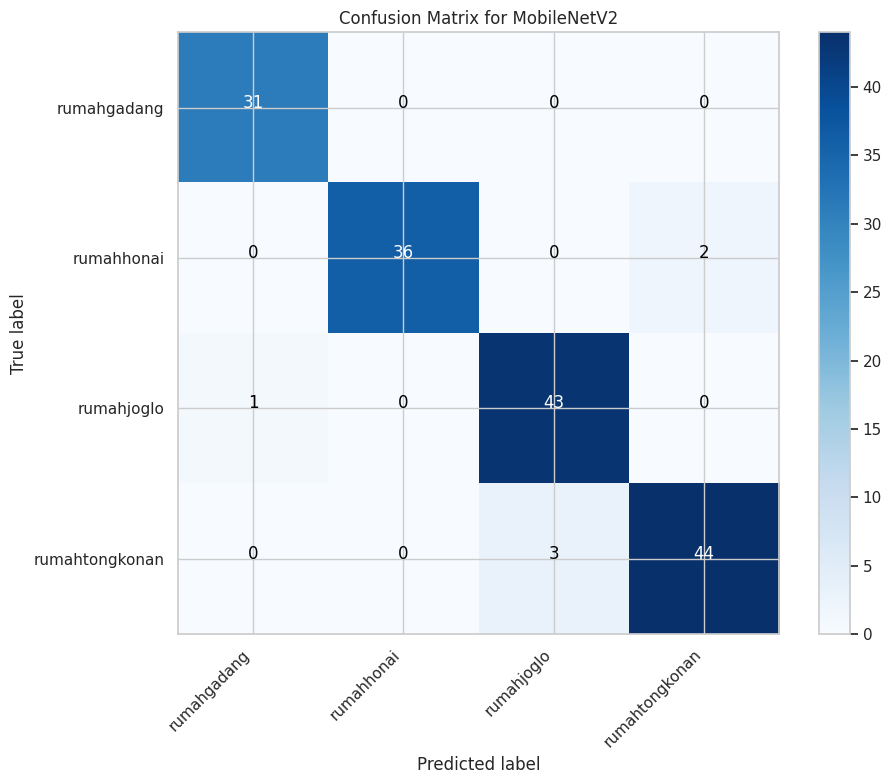


Classification Report:
                precision    recall  f1-score   support

   rumahgadang       0.97      1.00      0.98        31
    rumahhonai       1.00      0.95      0.97        38
    rumahjoglo       0.93      0.98      0.96        44
rumahtongkonan       0.96      0.94      0.95        47

      accuracy                           0.96       160
     macro avg       0.97      0.97      0.96       160
  weighted avg       0.96      0.96      0.96       160



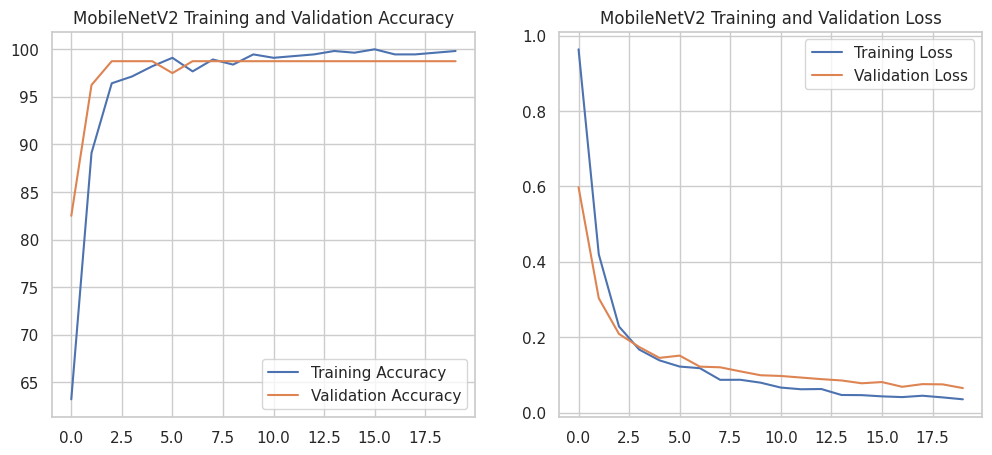

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



--- Memulai DenseNet121 ---


100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s]


Model DenseNet121 loaded with 4100 trainable parameters.

--- Training DenseNet121 ---
Epoch 1/20, Train Loss: 1.1177, Train Acc: 59.64%, Val Loss: 0.7333, Val Acc: 86.25%
Epoch 2/20, Train Loss: 0.5230, Train Acc: 92.32%, Val Loss: 0.3934, Val Acc: 95.00%
Epoch 3/20, Train Loss: 0.3259, Train Acc: 95.71%, Val Loss: 0.2860, Val Acc: 97.50%
Epoch 4/20, Train Loss: 0.2276, Train Acc: 97.14%, Val Loss: 0.2279, Val Acc: 97.50%
Epoch 5/20, Train Loss: 0.1955, Train Acc: 97.50%, Val Loss: 0.2193, Val Acc: 95.00%
Epoch 6/20, Train Loss: 0.1507, Train Acc: 98.21%, Val Loss: 0.1743, Val Acc: 98.75%
Epoch 7/20, Train Loss: 0.1378, Train Acc: 98.75%, Val Loss: 0.1716, Val Acc: 97.50%
Epoch 8/20, Train Loss: 0.1220, Train Acc: 98.39%, Val Loss: 0.1637, Val Acc: 95.00%
Epoch 9/20, Train Loss: 0.1149, Train Acc: 97.86%, Val Loss: 0.1482, Val Acc: 97.50%
Epoch 10/20, Train Loss: 0.0857, Train Acc: 99.29%, Val Loss: 0.1409, Val Acc: 98.75%
Epoch 11/20, Train Loss: 0.0815, Train Acc: 99.29%, Val Loss: 

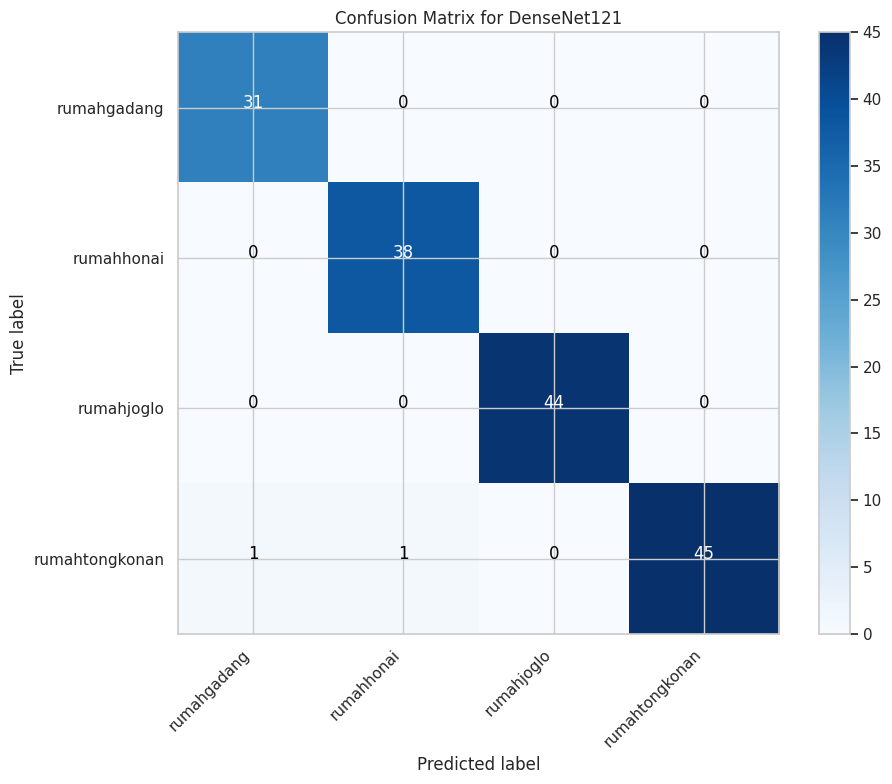


Classification Report:
                precision    recall  f1-score   support

   rumahgadang       0.97      1.00      0.98        31
    rumahhonai       0.97      1.00      0.99        38
    rumahjoglo       1.00      1.00      1.00        44
rumahtongkonan       1.00      0.96      0.98        47

      accuracy                           0.99       160
     macro avg       0.99      0.99      0.99       160
  weighted avg       0.99      0.99      0.99       160



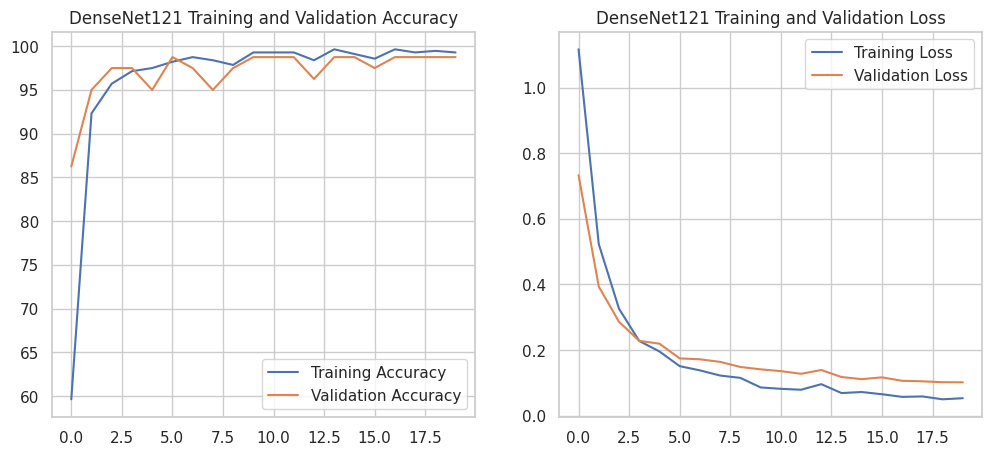

In [13]:
# Cell 13: Run Experiments for each model (Same as previous MobileNetV2, VGG16, DenseNet121)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20 # Anda bisa menyesuaikan jumlah epoch

model_results = {}

# --- VGG16 ---
print("\n--- Memulai VGG16 ---")
vgg_model = get_pretrained_model("VGG16", num_classes).to(device)
print(f"Model VGG16 loaded with {sum(p.numel() for p in vgg_model.parameters() if p.requires_grad)} trainable parameters.")
vgg_metrics = train_and_evaluate_model(vgg_model, train_loader, val_loader, test_loader, num_classes, epochs, device, "VGG16", class_names)
model_results["VGG16"] = {"Accuracy": vgg_metrics['accuracy'], "F1-Score": vgg_metrics['f1_score']}
plot_training_history(vgg_metrics['history'], "VGG16")
# Optional: Save the trained model
# torch.save(vgg_model.state_dict(), 'vgg16_rumah_adat.pth')


# --- MobileNetV2 ---
print("\n--- Memulai MobileNetV2 ---")
mobilenet_model = get_pretrained_model("MobileNetV2", num_classes).to(device)
print(f"Model MobileNetV2 loaded with {sum(p.numel() for p in mobilenet_model.parameters() if p.requires_grad)} trainable parameters.")
mobilenet_metrics = train_and_evaluate_model(mobilenet_model, train_loader, val_loader, test_loader, num_classes, epochs, device, "MobileNetV2", class_names)
model_results["MobileNetV2"] = {"Accuracy": mobilenet_metrics['accuracy'], "F1-Score": mobilenet_metrics['f1_score']}
plot_training_history(mobilenet_metrics['history'], "MobileNetV2")
# Optional: Save the trained model
# torch.save(mobilenet_model.state_dict(), 'mobilenetv2_rumah_adat.pth')


# --- DenseNet121 ---
print("\n--- Memulai DenseNet121 ---")
densenet_model = get_pretrained_model("DenseNet121", num_classes).to(device)
print(f"Model DenseNet121 loaded with {sum(p.numel() for p in densenet_model.parameters() if p.requires_grad)} trainable parameters.")
densenet_metrics = train_and_evaluate_model(densenet_model, train_loader, val_loader, test_loader, num_classes, epochs, device, "DenseNet121", class_names)
model_results["DenseNet121"] = {"Accuracy": densenet_metrics['accuracy'], "F1-Score": densenet_metrics['f1_score']}
plot_training_history(densenet_metrics['history'], "DenseNet121")
# Optional: Save the trained model
# torch.save(densenet_model.state_dict(), 'densenet121_rumah_adat.pth')

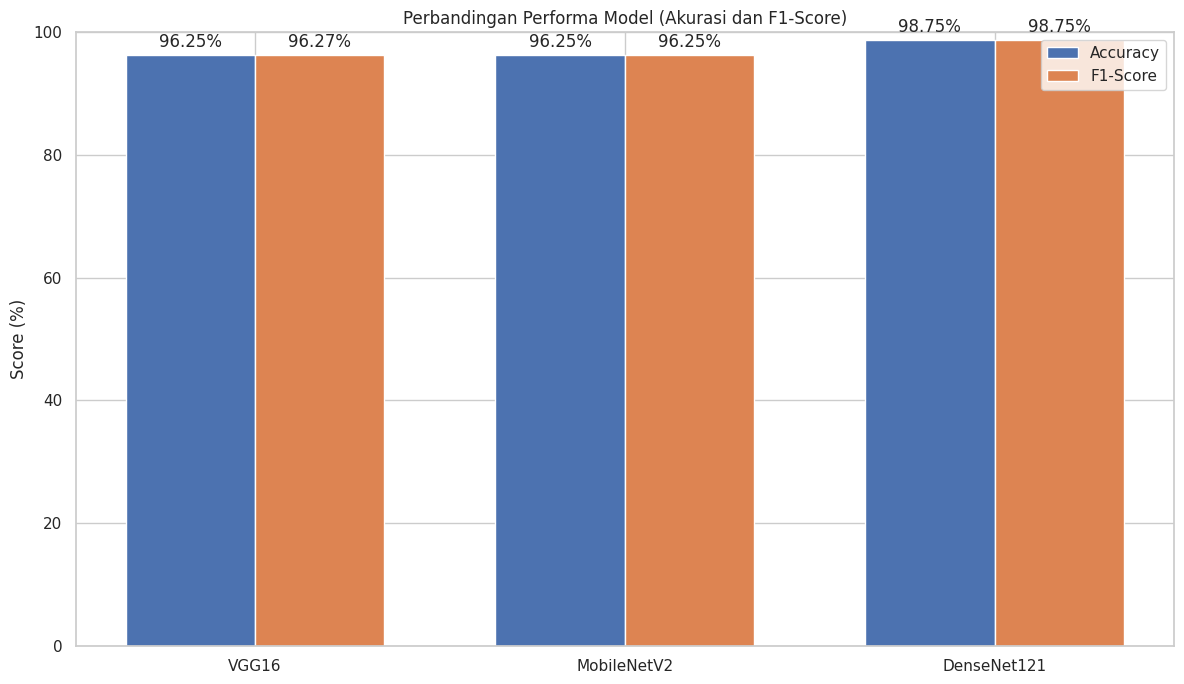

In [14]:
# Cell 14: Create Comparative Bar Chart for F1-Score and Accuracy (NO CHANGE NEEDED)
models_compared = list(model_results.keys())
accuracies = [model_results[model]["Accuracy"] for model in models_compared]
f1_scores = [model_results[model]["F1-Score"] * 100 for model in models_compared] # Dikalikan 100

x = np.arange(len(models_compared))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score')

ax.set_ylabel('Score (%)')
ax.set_title('Perbandingan Performa Model (Akurasi dan F1-Score)')
ax.set_xticks(x)
ax.set_xticklabels(models_compared)
ax.legend()
ax.set_ylim([0, 100]) # Scores are in percentage

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [15]:
# Cell 15: Display Summary Table (NO CHANGE NEEDED)
print("\n--- Ringkasan Performa Model ---")
summary_df = pd.DataFrame(model_results).T
summary_df['F1-Score'] = summary_df['F1-Score'] * 100 # Dikalikan 100 untuk tabel
print(summary_df.to_markdown(floatfmt=".2f"))


--- Ringkasan Performa Model ---
|             |   Accuracy |   F1-Score |
|:------------|-----------:|-----------:|
| VGG16       |      96.25 |      96.27 |
| MobileNetV2 |      96.25 |      96.25 |
| DenseNet121 |      98.75 |      98.75 |
